In [1]:
import numpy as np
import pandas as pd
import json

### json

In [2]:
file_path = "/data/data_full.json"

with open(file_path, 'r') as json_file:
    data = json.load(json_file)

In [3]:
# unpacking json
records = []
for identifier, value in data.items():
    trials = value["log"]["trials"]
    for trial in trials:
        record = {
            "identifier": identifier,
            "date": value["date"], 
            "condition": value["log"]["condition"],
            "trial": trial["trial"],
            "end_time": trial["end_time"],
            "start_time": trial["start_time"],
            "target": trial["target"],
            "entered": trial["entered"],
            "part": trial["part"],
            "block": trial["block"],
        }
        records.append(record)

# df from the list of dictionaries
df = pd.DataFrame(records)

In [4]:
# filtering rows from the pilot
df.groupby('identifier')['date'].agg(list)
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['date'] >= '2023-08-10']

In [5]:
# filtering out empty trial (backend issue)
df = df.loc[df['trial'] != 32]


### metrics

In [6]:
# calculate wpm per trial
# from pypl: The WPM is calculated by dividing characters per second by five and then multiplying that with 60.

def calculate_wpm(row):
    characters_typed = len(row['entered']) # num of characters typed
    time_taken_sec = row['end_time'] - row['start_time'] # time taken
    wpm = ((characters_typed / time_taken_sec) / 5) * 60 # wpm 
    return wpm

df['wpm'] = df.apply(calculate_wpm, axis = 1)

In [7]:
# character error rate (from jiwer)

import jiwer

def calculate_cer(row):
    cer = jiwer.cer(row['target'], row['entered'])
    return cer

df['cer'] = df.apply(calculate_cer, axis = 1)

In [8]:
# low-quality data filtering

df = df[df['identifier'] != "5689069036109824"]

120

In [13]:
# filtering outliers with a mean 'cer' higher than 0.05 (as preregistered)
 
mean_cer_by_identifier = df.groupby('identifier')['cer'].mean()
identifiers_to_filter = mean_cer_by_identifier[mean_cer_by_identifier > 0.05].index
df = df[~df['identifier'].isin(identifiers_to_filter)]
df.reset_index(drop=True, inplace=True)

In [14]:
len(df['identifier'].value_counts())

115

### conditions

In [15]:
for index, row in df.iterrows():
    identifier = row['identifier']
    trial_num = row['trial']
    value = data.get(str(identifier), {})

    if value:
        trials = value["log"]["trials"]

        if trial_num < len(trials):
            trial = trials[trial_num]
            condition = value["log"]["condition"]
            part = trial["part"]
            keyboard = value["log"]["ux"][part]["keyboard"]

            # Assign the extracted "keyboard" value to the DataFrame
            df.at[index, 'keyboard'] = keyboard

In [16]:
print(df['wpm'].describe())

count    7360.000000
mean       11.016073
std         3.605295
min         0.364912
25%         8.487805
50%        10.736842
75%        13.333333
max        26.666667
Name: wpm, dtype: float64


In [17]:
print(df['cer'].describe())

count    7360.000000
mean        0.007698
std         0.027899
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.454545
Name: cer, dtype: float64


In [18]:
print('cognitive wpm MEAN:', df[df["keyboard"] == "cognitive"]["wpm"].mean(), ' SD:', df[df["keyboard"] == "cognitive"]["wpm"].std(),
      '\nbaseline wpm MEAN:', df[df["keyboard"] == "baseline"]["wpm"].mean(), ' SD:', df[df["keyboard"] == "baseline"]["wpm"].std(),
      '\ncognitive cer MEAN:', df[df["keyboard"] == "cognitive"]["cer"].mean(), ' SD:', df[df["keyboard"] == "cognitive"]["cer"].std(),
      '\nbaseline cer MEAN:', df[df["keyboard"] == "baseline"]["cer"].mean(), ' SD:', df[df["keyboard"] == "baseline"]["cer"].std())

cognitive wpm MEAN: 11.172397429921801  SD: 3.633132767663625 
baseline wpm MEAN: 10.859748421880036  SD: 3.570895577104584 
cognitive cer MEAN: 0.006948181819325593  SD: 0.02638643590498348 
baseline cer MEAN: 0.00844687695879667  SD: 0.02931789646092718


### tests

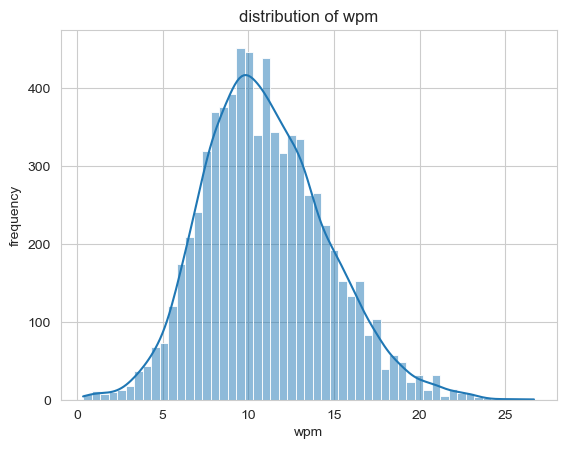

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data = df, x = 'wpm', kde = True)
plt.title('distribution of wpm')
plt.xlabel('wpm')
plt.ylabel('frequency')
plt.show()

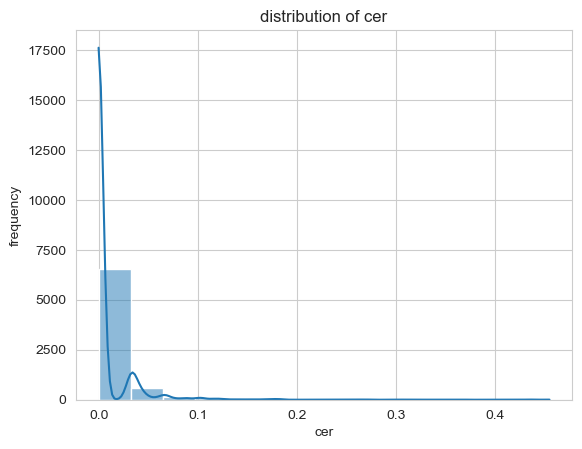

In [20]:
sns.histplot(data = df, x = 'cer', kde = True)
plt.title('distribution of cer')
plt.xlabel('cer')
plt.ylabel('frequency')
plt.show()

##### wpm

In [21]:
# block assignment

df['block'] = np.select(
    [
        (df['trial'] >= 0) & (df['trial'] <= 7) | (df['trial'] >= 33) & (df['trial'] <= 40),
        (df['trial'] >= 8) & (df['trial'] <= 15) | (df['trial'] >= 41) & (df['trial'] <= 48),
        (df['trial'] >= 16) & (df['trial'] <= 23) | (df['trial'] >= 49) & (df['trial'] <= 56),
        (df['trial'] >= 24) & (df['trial'] <= 31) | (df['trial'] >= 57) & (df['trial'] <= 64)
    ],
    [1, 2, 3, 4],
    default = None
)

In [24]:
import pingouin as pg

aov_interaction = pg.rm_anova(data = df, dv = 'wpm', within = ['keyboard', 'block'], subject = 'identifier')

# Calculate the effect size (partial eta-squared) manually
eta_squared = aov_interaction['SS'][0] / (aov_interaction['SS'][0] + aov_interaction['SS'][1])

# Calculate Cohen's d
n = len(df)  # Total number of observations
k = len(df['keyboard'].unique())  # Number of levels in the 'keyboard' factor

cohen_d = np.sqrt(eta_squared * (n - 1) / (n - k))

# Print ANOVA results, partial eta-squared, and Cohen's d
print(aov_interaction)
print(f"Partial Eta-Squared (η²): {eta_squared}")
print(f"Cohen's d: {cohen_d}")

             Source          SS  ddof1  ddof2         MS          F  \
0          keyboard   22.482363      1    114  22.482363   6.902736   
1             block  235.797464      3    342  78.599155  79.578216   
2  keyboard * block    4.023154      3    342   1.341051   1.360362   

          p-unc     p-GG-corr       ng2       eps  
0  9.790409e-03  9.790409e-03  0.003052  1.000000  
1  4.538799e-39  3.611222e-37  0.031111  0.947719  
2  2.547574e-01  2.554026e-01  0.000548  0.967248  
Partial Eta-Squared (η²): 0.08704652949663176
Cohen's d: 0.29505653642221413


/Users/olgaiarygina/opt/anaconda3/envs/PycharmProjects/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  """Entry point for launching an IPython kernel.


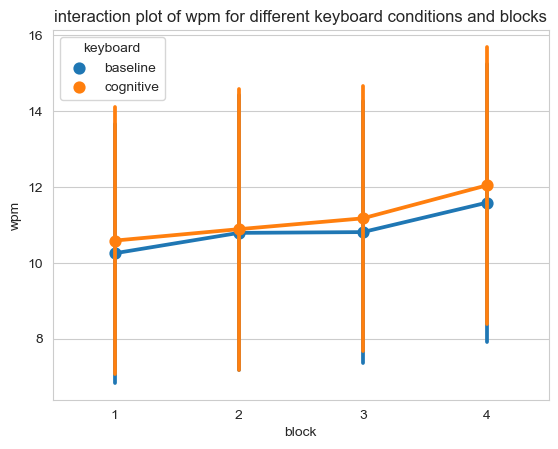

In [25]:
sns.pointplot(data = df, x = 'block', y = 'wpm', hue = 'keyboard', ci = 'sd')
plt.title('interaction plot of wpm for different keyboard conditions and blocks')
plt.xlabel('block')
plt.ylabel('wpm')
plt.show()

In [27]:
from statsmodels.stats.multicomp import MultiComparison

multi_comp = MultiComparison(df['wpm'], df['block'])
post_hoc_res = multi_comp.tukeyhsd()
print(post_hoc_res.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.4192 0.0021  0.1167 0.7217   True
     1      3   0.5722    0.0  0.2697 0.8747   True
     1      4   1.3949   -0.0  1.0924 1.6973   True
     2      3    0.153 0.5629 -0.1494 0.4555  False
     2      4   0.9757   -0.0  0.6732 1.2781   True
     3      4   0.8226    0.0  0.5202 1.1251   True
---------------------------------------------------


##### cer

In [28]:
cer_interaction = pg.rm_anova(data = df, dv = 'cer', within = ['keyboard', 'block'], subject = 'identifier')
print(cer_interaction)

             Source        SS  ddof1  ddof2        MS         F     p-unc  \
0          keyboard  0.000517      1    114  0.000517  2.271134  0.134570   
1             block  0.000243      3    342  0.000081  0.529839  0.662080   
2  keyboard * block  0.000199      3    342  0.000066  0.611632  0.607853   

   p-GG-corr       ng2       eps  
0   0.134570  0.002731  1.000000  
1   0.638354  0.001284  0.876409  
2   0.588808  0.001055  0.887934  


/Users/olgaiarygina/opt/anaconda3/envs/PycharmProjects/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  """Entry point for launching an IPython kernel.


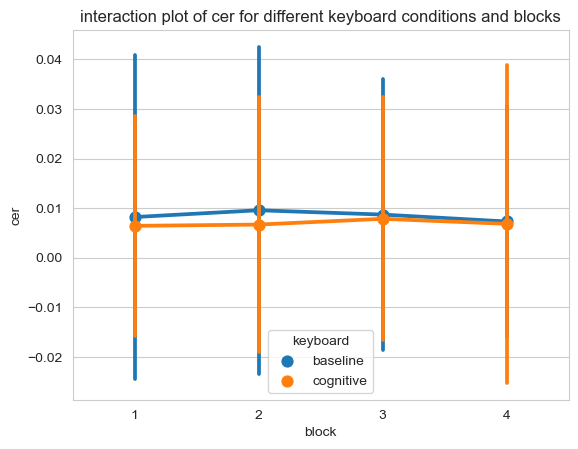

In [29]:
sns.pointplot(data = df, x = 'block', y = 'cer', hue = 'keyboard', ci = 'sd')
plt.title('interaction plot of cer for different keyboard conditions and blocks')
plt.xlabel('block')
plt.ylabel('cer')
plt.show()

In [30]:
df.to_csv('df_full_filtered.csv', index = False)